This notebook computes a linear regression with explanatory variables construction cost and living space per population and dependent variable rent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from src.plots import plot_regression, plot_coefficients
from tueplots import bundles

In [2]:
construction_cost = pd.read_csv('../data/construction_cost.csv', index_col=0)
living_space = pd.read_csv('../data/living_space.csv', index_col=0)
rent = pd.read_csv('../data/rent.csv', index_col=0)
population = pd.read_csv('../data/population.csv', index_col=0)

#### compute living space index per population index

In [3]:
((living_space.index == population.index) & (living_space.index == rent.index)).all()

True

In [4]:
ls_pp = living_space["total"] / population["total"]
# convert to index again
ls_pp = (ls_pp / ls_pp.loc[2015]) * 100
ls_pp_feature = ls_pp.values.reshape(-1, 1)

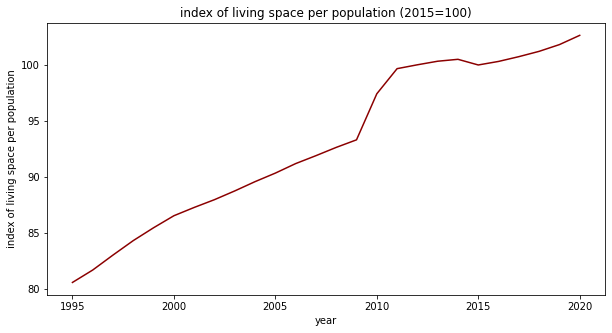

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(rent.index, ls_pp, color='darkred')
plt.xlabel('year')
plt.ylabel('index of living space per population')
plt.title('index of living space per population (2015=100)');

#### compute regression using the living space per population

In [6]:
observation = rent['rent'].values.reshape(-1 ,1)

fit = LinearRegression().fit(ls_pp_feature, observation)
prediction_lspp = fit.predict(ls_pp_feature)
coefs = fit.coef_
print('coef: ', round(coefs.item(), 4))

mse_lspp = np.mean((observation - prediction_lspp)**2)

coef:  1.1596


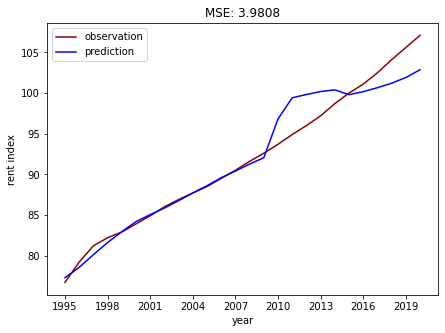

In [7]:
plot_regression(observation, prediction_lspp, rent.index, 'MSE: ' + str(round(mse_lspp, 4)))

#### add construction cost (only available from 2000 on)

coef:  -0.133 0.682


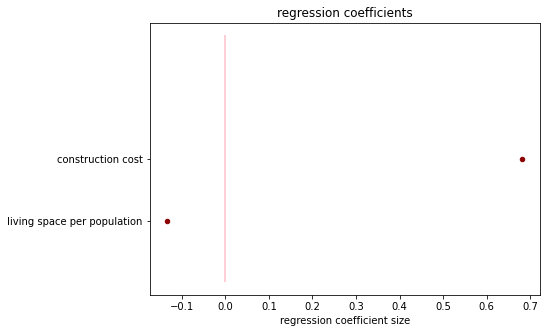

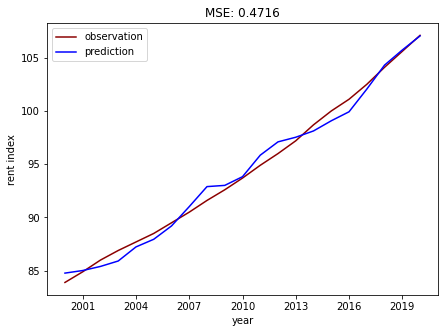

In [8]:
cc_feature = construction_cost['total cost'].values.reshape(-1, 1)
features = np.hstack((ls_pp_feature[5:], cc_feature))

observation = rent['rent'].values.reshape(-1 ,1)[5:]

fit = LinearRegression().fit(features, observation)
prediction_cc_lspp = fit.predict(features)
coefs = fit.coef_
print('coef: ', round(coefs[0, 0].item(), 4), round(coefs[0, 1].item(), 4))

mse = np.mean((observation - prediction_cc_lspp)**2)

feature_names = ['living space per population', 'construction cost']
plot_coefficients(feature_names, coefs)
plot_regression(observation, prediction_cc_lspp, construction_cost.index, 'MSE: ' + str(round(mse, 4)))

#### use only construction cost

In [9]:
fit = LinearRegression().fit(cc_feature, observation)
prediction_cc = fit.predict(cc_feature)
coefs = fit.coef_
print('coef: ', round(coefs.item(), 4))

mse_cc = np.mean((observation - prediction_cc)**2)

coef:  0.6185


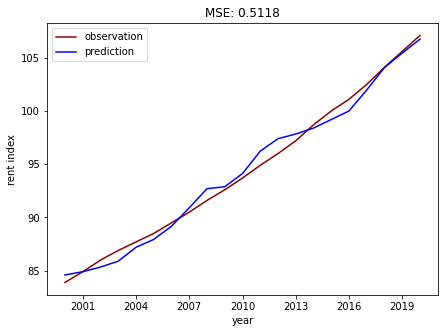

In [10]:
plot_regression(observation, prediction_cc, construction_cost.index, 'MSE: ' + str(round(mse_cc, 4)))

#### try to predict the last x years

In [11]:
years_to_predict = np.arange(0, 7)
ls_pp_coeffs = []
cc_coeffs = []
mses = []

features = np.hstack((ls_pp_feature[5:], cc_feature))
observation = rent['rent'].values.reshape(-1 ,1)[5:]

for year in years_to_predict:

    if year == 0:
        fit = LinearRegression().fit(features, observation)
    else:
        fit = LinearRegression().fit(features[:-year], observation[:-year])
    prediction = fit.predict(features)

    coefs = fit.coef_
    ls_pp_coeffs.append(coefs[0, 0])
    cc_coeffs.append(coefs[0, 1])

    mse = np.mean((observation - prediction)**2)
    mses.append(mse)

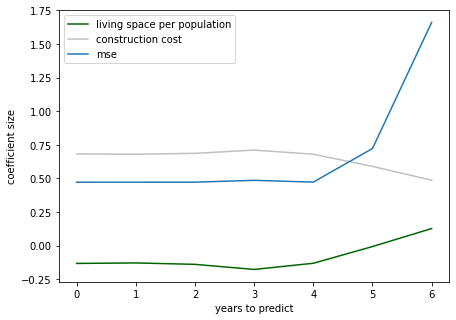

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(years_to_predict, ls_pp_coeffs, color='darkgreen', label='living space per population')
plt.plot(years_to_predict, cc_coeffs, color='silver', label='construction cost')
plt.plot(years_to_predict, mses, label='mse')
plt.legend()
plt.xlabel('years to predict')
plt.ylabel('coefficient size')
plt.show();

#### save relevant figures to fig

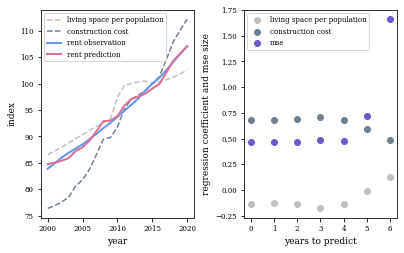

In [15]:
with plt.rc_context(bundles.neurips2021(usetex=False, family='serif')):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(construction_cost.index, ls_pp[5:], linestyle='dashed', linewidth=1.5, color='silver', label='living space per population')
    ax[0].plot(construction_cost.index, cc_feature, linestyle='dashed', linewidth=1.5, color='slategray', label='construction cost')
    ax[0].plot(construction_cost.index, observation, linewidth=2, color='cornflowerblue', label='rent observation')
    ax[0].plot(construction_cost.index, prediction_cc_lspp, linewidth=2, color='palevioletred', label='rent prediction')
    ax[0].legend()
    ax[0].set_xlabel('year')
    ax[0].set_ylabel('index')

    ax[1].scatter(years_to_predict, ls_pp_coeffs, color='silver', label='living space per population')
    ax[1].scatter(years_to_predict, cc_coeffs, color='slategray', label='construction cost')
    ax[1].scatter(years_to_predict, mses, color='slateblue', label='mse')
    ax[1].legend()
    ax[1].set_xticks(np.arange(0, 7, 1))
    ax[1].set_xlabel('years to predict')
    ax[1].set_ylabel('regression coefficient and mse size')

plt.savefig('../fig/regression_exp_03.pdf', bbox_inches='tight')

In [13]:
#hypothesis test: did rent increase significantly in 2020 (use regression over year to subtract upward trend?)